## Global Temperature Time Series Analysis (a.k.a. Is it Hot in Here?)

This notebook contains a time series analysis using data of monthly global temperature deviations (that's deviations from the mean between years 1951 and 1980). The data contains monthly observations from the year 1880 to 2018. The objective is to forecast global temperatures in the coming years.

In particular, this notebook will compare three methods: ARIMA, RNN and Prophet (by Facebook).

**Disclaimer -** *It's well known that the recognition of climate change as a threat has and will continue to inspire actions attempting to counteract the observed upward trend in temperatures. It's almost impossible to anticipate the extent and outcome of such actions, and therefore any prediction of temperature changes for the next, say 100 years, is likely to be off. In that light, the results from these analyses are for illustrative purposes only, not actual scientific predictions. I do not claim them to be valid or accurate, much less do I recommend for them to be used to drive any sort of decisions--except that of sharing this report if you find it useful :) I do recommend you do that.*

#### Sources:
1. Data: https://data.giss.nasa.gov/gistemp/
2. https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
3. https://www.youtube.com/watch?v=e8Yw4alG16Q
4. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
5. https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [387]:
from IPython.display import HTML

HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {
 $('div.input').show();}code_show = !code_show} $( document ).ready(code_toggle);</script>

The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [85]:
# Import Libraries

# General
import os
import itertools
import math
import warnings
import ast

# Data 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from statsmodels.graphics.tsaplots import plot_acf

# Dates
from datetime import datetime, timedelta
from collections import OrderedDict

# Statistical Models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# RNN
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import Sequential

# Prophet
from fbprophet import Prophet

# Models
from sklearn.model_selection import GridSearchCV

## 0. Load Data

In [2]:
# Load Data

dir_path = os.path.dirname(os.path.abspath("__file__"))
file_path = os.path.join(dir_path, "Global Means Anomalies.csv")

df = pd.read_csv(file_path)

# Get Column names from first row (file was not structured so it could do so automatically)
df_header = df.iloc[0]
df = df[1:]
df.columns = df_header
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1,1880,-0.28,-0.17,-0.1,-0.19,-0.11,-0.22,-0.2,-0.08,-0.15,-0.22,-0.19,-0.22,-0.18,***,***,-0.13,-0.17,-0.19
2,1881,-0.14,-0.16,0.05,0.05,0.03,-0.19,-0.06,-0.02,-0.13,-0.2,-0.21,-0.1,-0.09,-0.1,-0.17,0.04,-0.09,-0.18
3,1882,0.15,0.16,0.04,-0.18,-0.15,-0.25,-0.2,-0.05,-0.09,-0.24,-0.15,-0.24,-0.1,-0.09,0.07,-0.1,-0.17,-0.16
4,1883,-0.31,-0.38,-0.12,-0.17,-0.19,-0.12,-0.08,-0.15,-0.2,-0.13,-0.22,-0.15,-0.19,-0.19,-0.31,-0.16,-0.11,-0.18
5,1884,-0.15,-0.08,-0.36,-0.42,-0.36,-0.4,-0.34,-0.26,-0.27,-0.23,-0.29,-0.28,-0.29,-0.28,-0.13,-0.38,-0.33,-0.26


In [3]:
# Create list of year-mo
start_date = "{}-01".format(df['Year'].iloc[0])
end_date = "{}-12".format(df['Year'].iloc[-1])
year_month = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()
dates = pd.to_datetime(year_month, infer_datetime_format=True)

# Drop Extra Columns
cols_to_drop = ['Year', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']
df_cleaned = df.drop(cols_to_drop, axis=1)

# Stack Columns into one: time_series data frame
ts = np.asarray(df_cleaned.stack())

# Create Final DataFrame
ts = pd.DataFrame(data=pd.to_numeric(ts, errors='drop'), columns=['Deviation'], index=dates) 
ts.dropna(inplace=True)
ts.head()

,Deviation
1880-01-01,-0.28
1880-02-01,-0.17
1880-03-01,-0.10
1880-04-01,-0.19
1880-05-01,-0.11


In [4]:
# Split into Train and Test Sets
train_size = int(ts.shape[0]*0.85)
ts_train = ts.iloc[:train_size].copy()
ts_test = ts.iloc[train_size:].copy()

## 1. Visualization of Time Series

### Decompose into Trend, Seasonality and Residuals
First, we decompose our time series into its trend, seasonality and residual components.

[Text(0,0.5,'Residuals')]

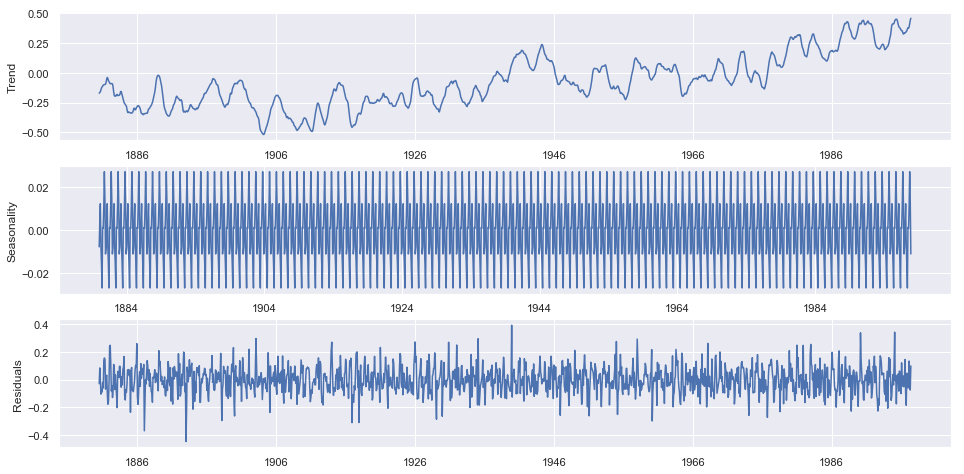

In [5]:
decomposition = sm.tsa.seasonal_decompose(ts_train['Deviation'], model='additive')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 8))
sns.lineplot(x=ts_train.index, y=decomposition.trend, ax=axes[0])
sns.lineplot(x=ts_train.index, y=decomposition.seasonal, ax=axes[1])
sns.lineplot(x=ts_train.index, y=decomposition.resid, ax=axes[2])
axes[0].set(ylabel='Trend')
axes[1].set(ylabel='Seasonality')
axes[2].set(ylabel='Residuals')

#### Analysis:
We can observe that there is clearly an upward trend from around 1913 to 1993. Years 1994-2018 were previously separated to form our test set, which we will use to test the predictions that our ARIMA, RNN and Prophet models make. Therefore, observations from those years are not included in this part of the analysis.

As for seasonality, we can observe a yearly pattern. The residuals look random (no clear pattern can be discerned) which means that all the trend and seasonality (or at least most of it) has been captured in the trend and seasonality components.

### Rolling Statistics
Time series models operate under the assumption that data is stationary. Without such behavior in the data, our predictions would systematically over/under estimate the true values. 

To test whether our data is stationary we fist analyze it's mean (rolling mean in this case) and variance graphically.

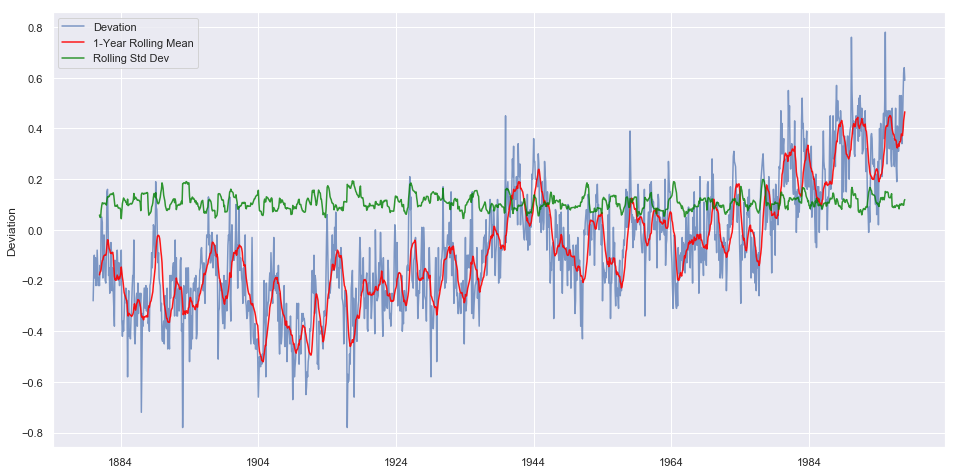

In [6]:
rol_mean = ts_train['Deviation'].rolling(window=12).mean()
rol_std = ts_train['Deviation'].rolling(window=12).std()

# Plot with Rolling Stats_train
fig = plt.figure(figsize=(16, 8))
sns.lineplot(x=ts_train.index, y=ts_train['Deviation'], data=ts_train, alpha=0.7)
sns.lineplot(x=ts_train.index, y=rol_mean, color='red', alpha=0.9)
sns.lineplot(x=ts_train.index, y=rol_std,  color='green', alpha=0.8)
plt.legend(['Devation', '1-Year Rolling Mean', 'Rolling Std Dev'], loc=2)

#### Analysis:
 Does the time series graph above look stationary?
1. **Constant Mean Over Time -** This assumption is violated as we can clearly see how the red line (rolling mean) is increasing with time. For those who are not familiar with "global warming" and "climate change", this is what scientists mean when they say the planet is getting warmer: there is a clear upward trend in the oceans and atmosphere average temperatures over time.
2. **Homoscedasticity (constant variance over time) -** The variance seems to be staying flat, so this assumption holds.
3. **Constant Autocovariance Over Time -** It's hard to tell from the graph, but it this assumption does seem to hold. 

Now that we informed our decision graphically, we can perform a **Dickey-Fuller (DF)** test to determine if our time series is stationary.

In [7]:
# Dickey-Fuller Test
df_test = adfuller(ts_train['Deviation'], autolag='AIC')

df_output = pd.Series(df_test[0:4], index=['Test statistic', 'p-value', 'No. of Lags', 'No. of Observations'])
for key, value in df_test[4].items():
    df_output['Critical Value ({})'.format(key)] = value
    
print(df_output)

Test statistic            -1.520250
p-value                    0.523471
No. of Lags               24.000000
No. of Observations     1391.000000
Critical Value (1%)       -3.435060
Critical Value (5%)       -2.863620
Critical Value (10%)      -2.567877
dtype: float64


#### Analysis:
The p-value (with the null-hypothesis being that the data is non-stationary) is not low enough for us to accept the alternative hypothesis. Meaning, the data is non-stationary, as we concluded graphically before.

## 2. Make TS Stationary

There are various methods for making a time series stationary. Some are:
1. Regression fitting to remove the trend component
2. Moving average smoothing to remove both trend and seasonality
3. Differencing to both de-trend and de-seasonalize the data

The first model we are intending to use to forecast temperatures into the future is ARIMA. One of the components of ARIMA is the differencing parameter. Therefore, to determine what level of differencing we need to use (and also because differencing usually provides the best results when time series has both trend and seasonality components) we will use Differencing here. We will begin with d=1 and continue to a higher order (d=2, 3, ..) only if our data does not become stationary at d=1. This means we will deduct observation X(t-1) from X, for every X in our time series.

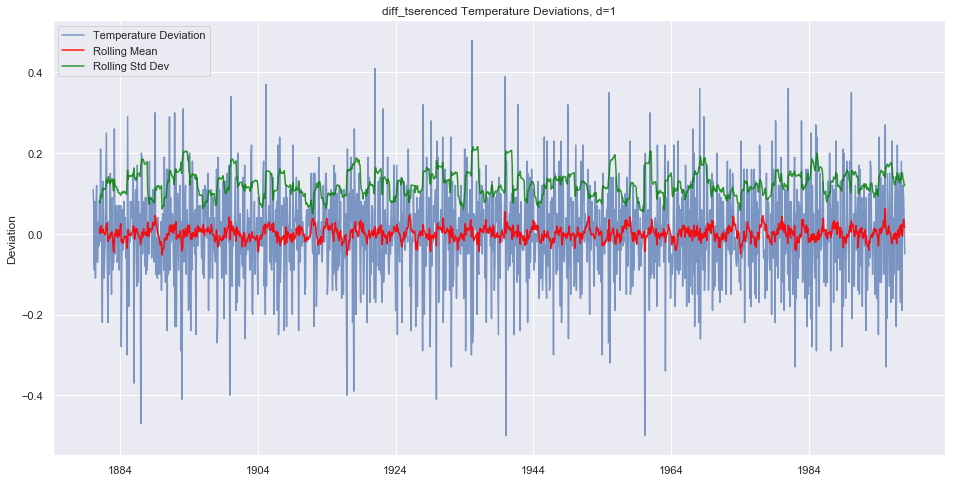

In [8]:
# Differencing to Convert Time Series to Stationary
diff_ts = ts_train['Deviation'] - ts_train['Deviation'].shift(1)
diff_ts.dropna(inplace=True)
diff_ts_rol_mean = diff_ts.rolling(window=12).mean()
diff_ts_rol_std = diff_ts.rolling(window=12).std()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
sns.lineplot(x=ts_train.index[1:], y=diff_ts, ax=ax, alpha=0.7)
sns.lineplot(x=ts_train.index[1:], y=diff_ts_rol_mean, color='red', ax=ax, alpha=0.9)
sns.lineplot(x=ts_train.index[1:], y=diff_ts_rol_std,  color='green', ax=ax, alpha=0.8)
ax.set_title('diff_tserenced Temperature Deviations, d=1')
plt.legend(['Temperature Deviation', 'Rolling Mean', 'Rolling Std Dev'], loc=2)

In [9]:
# Dickey-Fuller Test on Differenced Data
df_diff_test = adfuller(diff_ts, autolag='AIC')

df_diff_output = pd.Series(df_diff_test[0:4], index=['Test statistic', 'p-value', 'No. of Lags', 'No. of Observations'])
for key, value in df_diff_test[4].items():
    df_diff_output['Critical Value ({})'.format(key)] = value
    
print(df_diff_output)

Test statistic         -1.129562e+01
p-value                 1.346052e-20
No. of Lags             2.300000e+01
No. of Observations     1.391000e+03
Critical Value (1%)    -3.435060e+00
Critical Value (5%)    -2.863620e+00
Critical Value (10%)   -2.567877e+00
dtype: float64


#### Analysis:

The graph above looks much more stationary than our previous time series because both the mean and variance stay constant with time. The method used was differencing, with d=1.

As for the DF test, our test statistic is large enough and our p-value small enough (in fact it's very small) to accept the alternative hypothesis: the time series is now stationary.

One thing we did not do, but is often helpful is to transform the data (such as taking the log, square root, or multiplying values by an exponent). Our data does not seem to benefit from these transformations, but feel free to try them yourself.

### Parameters Selection

Before fitting a model, we should get an understanding for the type of process our time series follows. A time series can either be an Auto-Regressive (AR) or a Moving Average (MA) process, or something in between. In simple terms, observations in AR processes are correlated with the actual values of previous observations. In contrast, MA processes have observations that are correlated to the random noise (error) from previous observations. 

To get an understanding of what type of signature our data exhibits, we look at the APF and PACF plots.

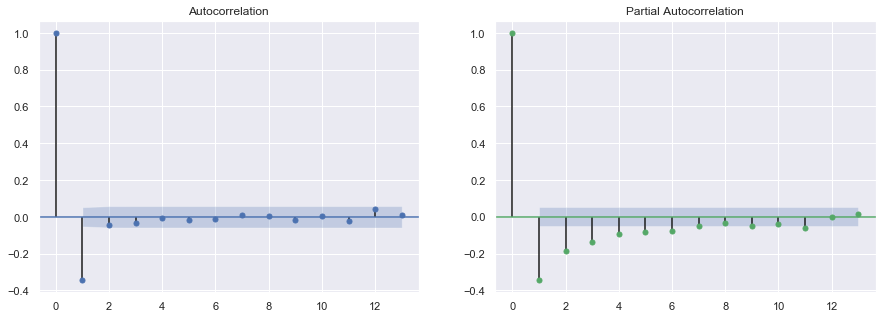

In [10]:
f, axs = plt.subplots(1, 2,figsize=(15,5))
f1 = sm.graphics.tsa.plot_acf(diff_ts, lags=13, ax=axs[0])
f2 = sm.graphics.tsa.plot_pacf(diff_ts, lags=13, ax=axs[1], color='g')

#### Analysis:

From the plots above we can infer that our time series displays a MA(1) signature. 

That's because the plot showing the more abrupt cutoff is our ACF, with only 1 lag correlation as being significant. PACF on the other hand is significant up to 6 lags. That indicates an MA signature. We determine it's of degree 1 because the ACF cuts off after 1 lag, so observations are primarily a function of the random noise from previous observations.

With this we're ready to fit a model. Let's begin with ARIMA.

## 3. Build and Test ARIMA Model

Although the decision of which parameters (p, d, q) to choose is usually not too complicated, considering that we already know we differenced once, so d=1, and we already observed an MA(1) signature from our ACF and PACF plots so q=1 is a safe assumption, in the spirit of evaluating all avenues and since it would not take much time to test, we will proceed to test different combination of parameters. Additionally, since we will in fact not be doing ARIMA but SARIMAX instead, which accounts for seasonality components in a more robust way, we also need to determine P, D, Q and m.

### Parameter Selection via Computation of AIC, BIC and RSS

To determine the best combination of parameters we will evaluate a combined score of AIC, BIC and RSS, and choose whichever has the lowest score.

In [11]:
# Coefficients to try
p_coeff = [0, 1, 2]
d_coeff = [1]
q_coeff = [0, 1, 2]

# Create lists with all combinations of coefficients from values above
orders_list = [x for x in itertools.product(p_coeff, d_coeff, q_coeff)]
seasonal_list = [(i[0], i[1], i[2], 12) for i in orders_list]

In [12]:
warnings.filterwarnings("ignore")

# Loop through all orders (combinations of p, d, and q coefficients):
errors_list = []

for (order, season) in itertools.product(orders_list, seasonal_list):
    try:
        model = SARIMAX(ts_train, order=order, seasonal_order=season, freq=diff_ts.index.inferred_freq,
                         enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=-1)

        aic = model_fit.aic
        bic = model_fit.bic
        rss = sum((model_fit.fittedvalues - ts_train['Deviation'])**2)

        errors = [order, season, aic, bic, rss]
        errors_list.append(errors)
        
    except: continue
        
errors_df = pd.DataFrame(errors_list, columns=['order', 'seasonal', 'aic', 'bic', 'RSS'])

In [13]:
# Save Errors Table
errors_df.to_csv('Parameters_Errors_Table', header=True, index=False)

# # Load Errors Table
# errors_df = pd.read_csv('Parameters_Errors_Table')
# errors_df['order'] = errors_df['order'].apply(lambda x: ast.literal_eval(x))
# errors_df['seasonal'] = errors_df['seasonal'].apply(lambda x: ast.literal_eval(x))

# Compute a combined score and select parameters that minimize it
errors_df['Combined Scores'] = ((errors_df['aic'] + errors_df['bic']) / 
                                (2*np.max(np.abs(errors_df['aic']))) + errors_df['RSS']/np.max(errors_df['RSS']))

best_order = (errors_df['order'].iloc[errors_df['Combined Scores'].idxmin(axis=0)],
              errors_df['seasonal'].iloc[errors_df['Combined Scores'].idxmin(axis=0)])
print("The Combination of Parameters With the Lowest Error is: {}".format(best_order))
print("\nRankings from Lowest to Highest Scores:")
display(errors_df.sort_values(by='Combined Scores', ascending=True).head(5))

The Combination of Parameters With the Lowest Error is: ((1, 1, 2), (0, 1, 1, 12))

Rankings from Lowest to Highest Scores:


,order,seasonal,aic,bic,RSS,Combined Scores
46,"(1, 1, 2)","(0, 1, 1, 12)",-2040.244404,-2014.374613,16.613427,-0.556350
53,"(1, 1, 2)","(2, 1, 2, 12)",-2033.651569,-1992.333806,16.350083,-0.556263
73,"(2, 1, 2)","(0, 1, 1, 12)",-2040.553685,-2009.509936,16.625666,-0.554912
49,"(1, 1, 2)","(1, 1, 1, 12)",-2038.240362,-2007.196612,16.613525,-0.554097
76,"(2, 1, 2)","(1, 1, 1, 12)",-2035.970153,-1999.752445,16.651245,-0.550725


#### Analysis:
That is consistent with the MA trend signature we had signaled earlier, but it seems to signal that an MA(2) will fit the data better than an MA(1). Now let's look at how it matches our data. 

C:\Users\dbejarano\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\dbejarano\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA Model AIC: -2182.53542413591
ARIMA Model BIC: -2156.3035837353978
ARIMA Model RSS: 17.429549696386363
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8692      0.025     34.947      0.000       0.820       0.918
ma.L1         -1.3931      0.036    -38.304      0.000      -1.464      -1.322
ma.L2          0.4026      0.034     11.760      0.000       0.335       0.470
ma.S.L12      -0.9507      0.009   -107.898      0.000      -0.968      -0.933
sigma2         0.0120      0.000     32.034      0.000       0.011       0.013


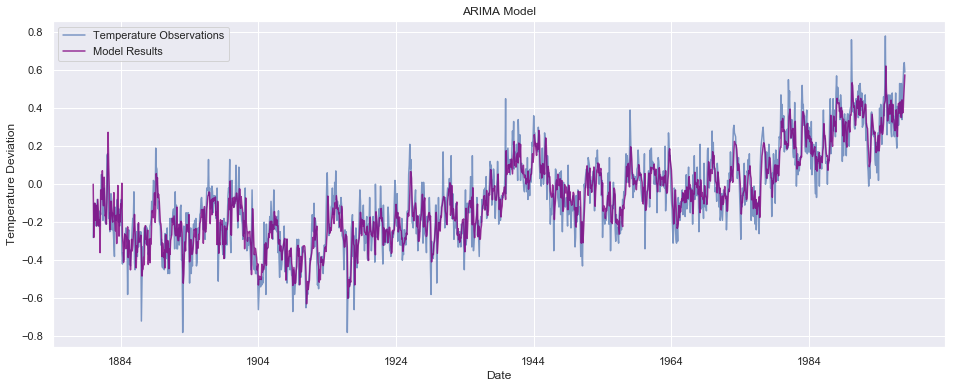

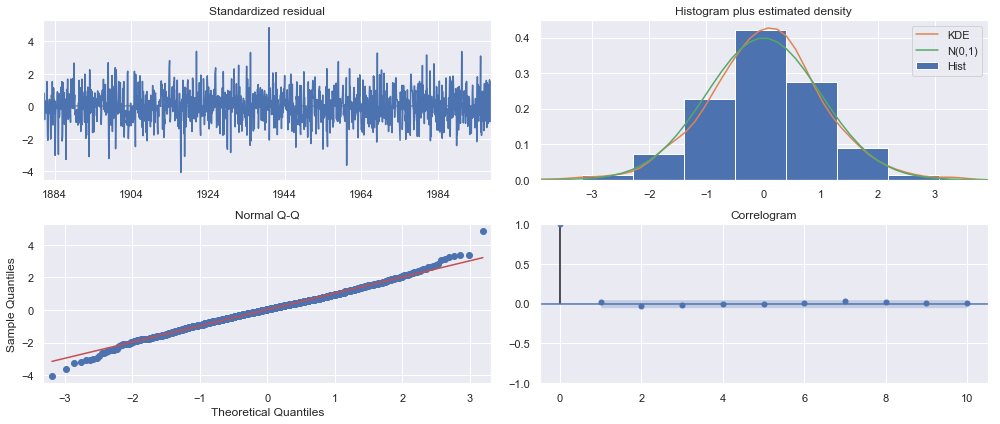

In [14]:
# Train ARIMA Model w/ Best Parameters
arima_model = SARIMAX(ts_train, order=best_order[0], seasonal_order=best_order[1])
arima_results = arima_model.fit(disp=-1)

plt.figure(figsize=(16, 6))
plt.plot(ts_train, alpha=0.7)
plt.plot(arima_results.fittedvalues, color='purple', alpha=0.8)
plt.ylabel('Temperature Deviation')
plt.xlabel('Date')
plt.title('ARIMA Model')
plt.legend(['Temperature Observations', 'Model Results'], loc=2)

# Test BIC AND AIC
print("ARIMA Model AIC: {}".format(arima_results.aic))
print("ARIMA Model BIC: {}".format(arima_results.bic))
print("ARIMA Model RSS: {}".format(sum((arima_results.fittedvalues - ts_train['Deviation'])**2)))

# Results Table
print(arima_results.summary().tables[1])

# Diff Model Diagnostics
diagnostics = arima_results.plot_diagnostics(figsize=(14, 6))
plt.tight_layout()

#### Analysis:
We can observe the model fits our data very closely. An analysis of the residuals confirms this because of the following:
1. The standardized residual plot appears to be random noise, with no discernable trend or seasonality.
2. The KDE curve matches the N(0,1) curve very closely, meaning that the residuals are, as we would expect, normally distributed with mean 0 and standard deviation of 1.
3. The Normal Q-Q plot confirms the normal distribution of the residuals as they very closely match the straight red line.
4. Our correlogram shows how residuals have no significant correlation with lags in time, so the model captured the great majority of this relationship.

### Dynamic vs Static Forecasts on Left-out Test Set

Static Predictions MSE: 0.012565462431436754
Forecast MSE: 0.02876309300693252


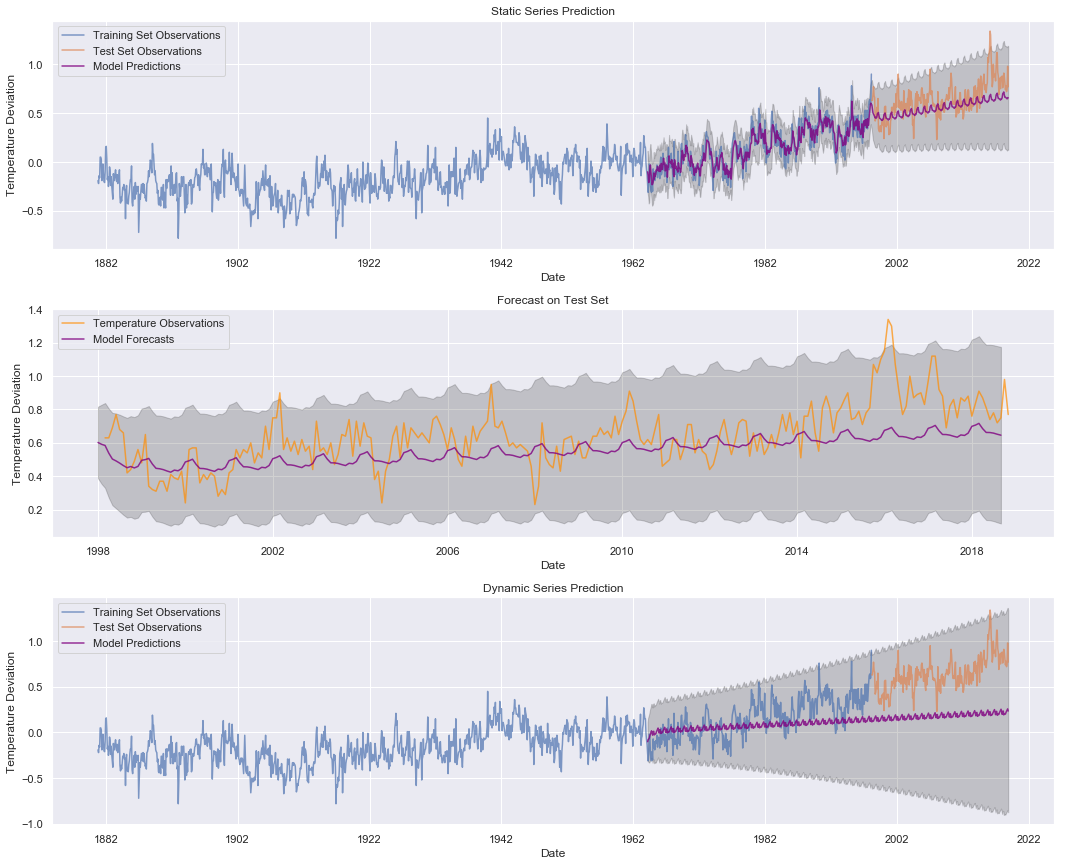

In [381]:
f, axs = plt.subplots(3, 1,figsize=(15,12))

# STATIC
pred_static = arima_results.get_prediction(start=ts_train.index[1000], end=ts_test.index[-1],
                                           dynamic=False, full_results=True)
pred_static_ci = pred_static.conf_int()

axs[0].fill_between(pred_static_ci.index,
                pred_static_ci.iloc[:, 0],
                pred_static_ci.iloc[:, 1], color='k', alpha=.2)
axs[0].plot(ts_train, alpha=0.7)
axs[0].plot(ts_test, alpha=0.7)
axs[0].plot(pred_static.predicted_mean, color='purple', alpha=0.8)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature Deviation')
axs[0].legend(['Training Set Observations', 'Test Set Observations', 'Model Predictions'])
axs[0].set_title('Static Series Prediction')

# FORECAST
pred_forecast = arima_results.get_forecast(steps=len(ts_test))
pred_forecast_ci = pred_forecast.conf_int()

axs[1].fill_between(pred_forecast_ci.index,
                pred_forecast_ci.iloc[:, 0],
                pred_forecast_ci.iloc[:, 1], color='k', alpha=.2)
axs[1].plot(ts.iloc[-len(ts_test):], alpha=0.7, color='darkorange')
axs[1].plot(pred_forecast.predicted_mean, color='purple', alpha=0.8)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature Deviation')
axs[1].legend(['Temperature Observations', 'Model Forecasts'])
axs[1].set_title('Forecast on Test Set')
plt.tight_layout()

# DYNAMIC
pred_dynamic = arima_results.get_prediction(start=ts_train.index[1000], end=ts_test.index[-1],
                                           dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
axs[2].fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
axs[2].plot(ts_train, alpha=0.7)
axs[2].plot(ts_test, alpha=0.7)
axs[2].plot(pred_dynamic.predicted_mean, color='purple', alpha=0.8)
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature Deviation')
axs[2].legend(['Training Set Observations', 'Test Set Observations', 'Model Predictions'])
axs[2].set_title('Dynamic Series Prediction')


print('Static Predictions MSE: {}'.format(np.mean((pred_static.predicted_mean[:-len(ts_test)] - 
                                                      ts_train['Deviation'].iloc[1000:])**2)))
print('Forecast MSE: {}'.format(np.mean((pred_static.predicted_mean[-len(ts_test):] - 
                                                      ts_test['Deviation'])**2)))

#### Analysis:
The first thing to notice from the plots above, is that the results are not very good. Let's break them down by plot:
1. Static predictions take all the previous observations to make a prediction. The first plot shows how closely those predictions are on the training set. Once we get to the test set (observations which are not fed into the model) the static predictions get considerably worse. They effectively become dynamic predictions. We can see that the MSE for the static prediction (the training set part) is half that of the dynamic forecast (test set portion).
2. The second plot shows a closer look at the dynamic forecast portion of the first plot. We can see the model does a good job at predicting the overall trend, but poorly follows seasonality and noise.
2. Dynamic predictions only use observations up to a certain point, as previously mentioned. If we make that stopping point around year 1964 we see how the model predicts much lower temperatures than we have observed in the last several years. As observed in the confidence boundaries, predictions tend to get worse the further in the future we forecast.

Now let's compare these results to those obtained by training a Recurrent Neural Network next. 

## 4. Build and Test RNN Model

We will first change the shape of our dataframe so that each row contains a value at the present time (say we are at time t=10), and values for the 10 previous lags (from t=1 to t=9). That way, our model will be predicting t=10 based on the values from t=1 to t=9. Before doing that though, our Neural Network model will very much like to have our data standardized (even though for the Temperature Deviation measurements values are pretty constant, it is still good practice). 

In [244]:
# Prepare Data for Model
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_rnn = pd.DataFrame(scaler.fit_transform(ts.values))

window_size = 10

scaled_ts_copy = ts_rnn.copy()

for i in range(window_size):
    ts_rnn = pd.concat([ts_rnn, scaled_ts_copy.shift((i+1))], axis=1)
    
ts_rnn = ts_rnn.dropna(axis=0).copy()

ts_rnn.columns = ['Lag{}'.format(i) for i in range(ts_rnn.shape[1])]
ts_rnn.head()

,Lag0,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10
10,-0.443396,-0.471698,-0.405660,-0.339623,-0.452830,-0.471698,-0.367925,-0.443396,-0.358491,-0.424528,-0.528302
11,-0.471698,-0.443396,-0.471698,-0.405660,-0.339623,-0.452830,-0.471698,-0.367925,-0.443396,-0.358491,-0.424528
12,-0.396226,-0.471698,-0.443396,-0.471698,-0.405660,-0.339623,-0.452830,-0.471698,-0.367925,-0.443396,-0.358491
13,-0.415094,-0.396226,-0.471698,-0.443396,-0.471698,-0.405660,-0.339623,-0.452830,-0.471698,-0.367925,-0.443396
14,-0.216981,-0.415094,-0.396226,-0.471698,-0.443396,-0.471698,-0.405660,-0.339623,-0.452830,-0.471698,-0.367925


Now we must re-shape our dataframe so as to match the (num_samples, num_timestep, num_features) dimensionality our RNN expects.

In [255]:
# Reshape dataframe to match requirement of 3 dimensions (num_samples, num_timestep, num_features)
X_rnn = np.array(ts_rnn.iloc[:, 1:])[:,:, None]
y_rnn = ts_rnn.iloc[:, 0]

# Split into Train and Test Sets
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.15, shuffle=False)
ts_train, ts_test = train_test_split(ts[10:], test_size=0.15, shuffle=False)

We will be training a Recurrent Neural Network (RNN) of three LSTM layers, plus a dropout layer after each LSTM to regularize the network and (most likely) improve our results. The decision on the model architecture was made by following common practices, considering the size of our dataset, and trying different designs to ultimately choose the simplest one tha had a low enough validation score.

In [281]:
# Define Model
rnn_model = Sequential()
rnn_model.add(LSTM(input_shape=(window_size, 1), output_dim=window_size, return_sequences=True))
rnn_model.add(Dropout(0.5))
rnn_model.add(LSTM(128, return_sequences=True))
rnn_model.add(Dropout(0.5))
rnn_model.add(LSTM(128))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1))
rnn_model.add(Activation("linear"))

rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.summary()

history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=8, validation_split=0.2)

C:\Users\dbejarano\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 1), return_sequences=True, units=10)`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
dropout_39 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 10, 128)           71168     
_________________________________________________________________
dropout_40 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
__________

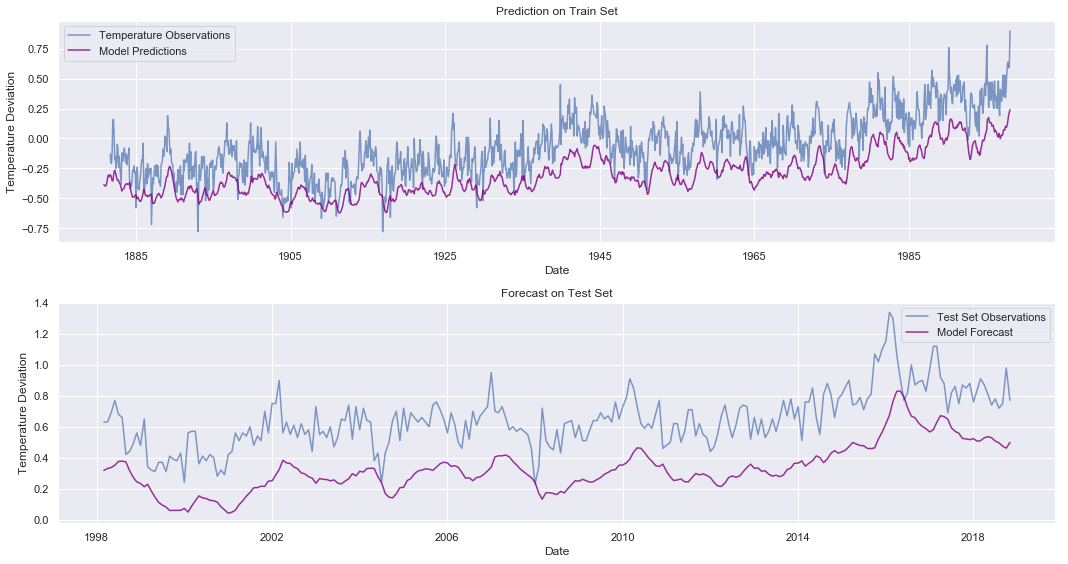

In [282]:
# Predict on Train Set
f, axs = plt.subplots(2, 1,figsize=(15,8))

rnn_preds_train = pd.DataFrame(rnn_model.predict(X_train_rnn), index=ts_train.index)

axs[0].plot(ts_train[10:], alpha=0.7)
axs[0].plot(rnn_preds_train, color='purple', alpha=0.8)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature Deviation')
axs[0].legend(['Temperature Observations', 'Model Predictions'])
axs[0].set_title('Prediction on Train Set')

# Predict on Test set
rnn_preds_test = pd.DataFrame(rnn_model.predict(X_test_rnn), index=ts_test.index)

axs[1].plot(ts_test, alpha=0.7)
axs[1].plot(rnn_preds_test, color='purple', alpha=0.8)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature Deviation')
axs[1].legend(['Test Set Observations', 'Model Forecast'])
axs[1].set_title('Forecast on Test Set')

plt.tight_layout()

#### Analysis:
The first plot shows how our model fits the training data. We can see that it does a good job at following both treand and seasonality. It however, is shifted down and consistently underestimates the temperature deviations. 

The same observations can be made about the forecasts on the test set. 

### Forecasts
The challenging part of a time series is not predicting on values we have data for, it's on forecasting into the future. To test the ability of our model to forecast temperatures in future years we will make predictions for years 2019-2050. This presents a commonly encountered issue: we trained our model to predict based on the previous 10 observations. But once we get to the end of 2019 all 10 previous observations (remember we have values for every month) are in the future. To deal with this issue, we will use predictions as input to make future predictions. Considering the nature of our data, it's unlikely this method will yield good results, but we will try this moving window approach.

In [283]:
# Combine Training and Testing Sets
X_rnn = np.concatenate([X_train_rnn, X_test_rnn], axis=0)
y_rnn = np.concatenate([y_train_rnn, y_test_rnn])

history_final = rnn_model.fit(X_rnn, y_rnn, epochs=8)

Epoch 1/8
1657/1657 [==============================] - 4s 2ms/step - loss: 0.0176
Epoch 2/8
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0164
Epoch 3/8
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0164
Epoch 4/8
1657/1657 [==============================] - 3s 2ms/step - loss: 0.0173
Epoch 5/8
1657/1657 [==============================] - 3s 2ms/step - loss: 0.0171A: 0s - loss: 
Epoch 6/8
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0165A: 2s - loss: 
Epoch 7/8
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0163
Epoch 8/8
1657/1657 [==============================] - 2s 1ms/step - loss: 0.0166


In [284]:
# Create list of dates
forecast_start_date = "{}-12".format(df['Year'].iloc[-1])
forecast_end_date = "{}-12".format(2050)
forecast_year_month = pd.date_range(forecast_start_date, forecast_end_date, freq='MS').strftime("%Y-%m").tolist()
forecast_dates = pd.to_datetime(forecast_year_month, infer_datetime_format=True)

In [285]:
# Create Moving Predictions

forecasts_rnn = []
n_predictions = ((2050 - 2018) * 12 + 1) # Predictions from Dec 2018 to Dec 2050
X = np.expand_dims(X_rnn[-1], axis=0)  # expand_dims changes our (10, 1) array to (1, 10, 1)

for n in range(n_predictions):
    forecast = np.expand_dims(rnn_model.predict(X), axis=0)
    X = np.concatenate([forecast, X[:, :9]], axis=1)
    forecasts_rnn.append(forecast[0, 0, 0])

Text(0.5,1,'Forecast to Year 2050')

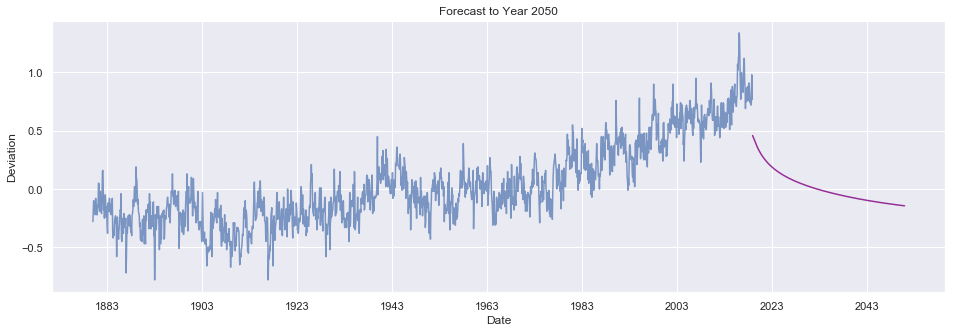

In [286]:
# Add Index to Forecasts

forecasts_rnn_df = pd.DataFrame(forecasts_rnn, index=forecast_dates)

# Plot Forecast Into the Future
fig = plt.figure(figsize=(16,  5))
plt.plot(ts, alpha=0.7)
plt.plot(forecasts_rnn_df, color='purple', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Deviation')
plt.title('Forecast to Year 2050')

#### Analysis:
This model is very optimistic. Turns out the planet will stop warming up in 2020. 

That's of course false. Our model does a bad job at predicting the future. Better results were in fact obtained by training a RNN with only two LSTM layers (not shown on this notebook). It still provided a smooth almost-straight line as output, but it was trending upwards. The reason for leaving the above results as they are is to emphasize how models can overfit to the data provided. In this case it appears that the model became too dependent on its closest previous values (say lag1, lag2 for instance) and once those started trending down the model simply continued on that path.

To finalize this time series analysis, let's test the results obtained using Prophet.

## 5. Build and Test Prophet Model

In [339]:
# Create Dataframe in format Prophet likes: ds and y columns
ts_prophet = ts.copy().reset_index()
ts_prophet.columns = ['ds', 'y']

ts_prophet_train, ts_prophet_test = train_test_split(ts_prophet, test_size=0.15, shuffle=False)

prophet_model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1, 
                       interval_width=0.95)
prophet_model.fit(ts_prophet_train)

future = prophet_model.make_future_dataframe(periods=len(ts_test), freq='MS')
prophet_forecast = prophet_model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dbejarano\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


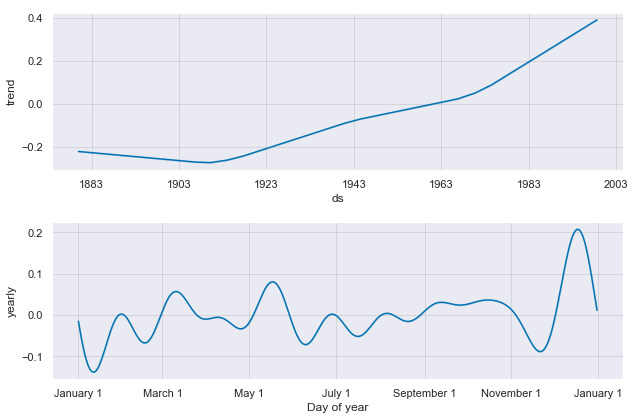

In [334]:
# Plot Time Series Components
f_comp = prophet_model.plot_components(prophet_forecast)

Text(0.5,1,'Temperature Observations and Prophet Model Predictions')

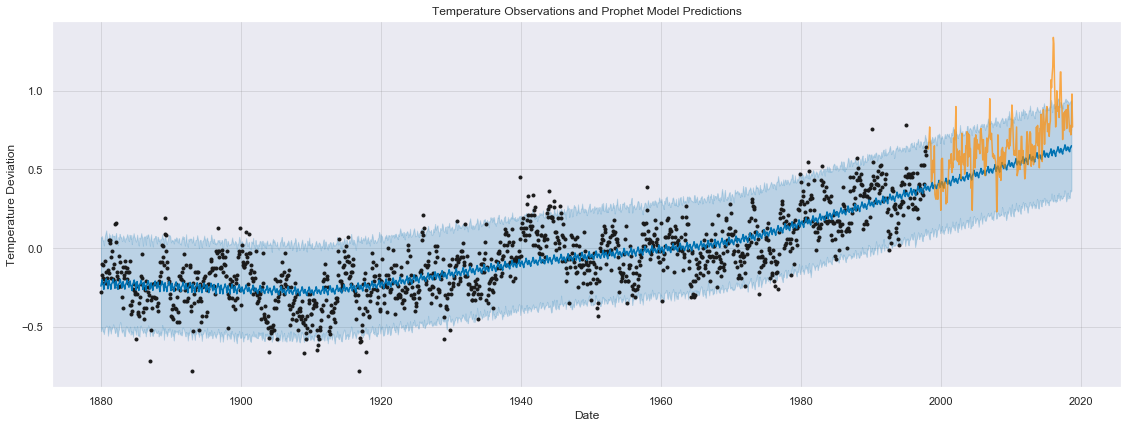

In [380]:
# Plot Observations and Prophet Predictions
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
prophet_model.plot(prophet_forecast, uncertainty=True, ax=ax, xlabel='Date', ylabel='Temperature Deviation')
plt.plot(ts_test, alpha=0.7, color='darkorange')
plt.title("Temperature Observations and Prophet Model Predictions")

#### Analysis:
The first observation to make about prophet is how simple it is to use.

Second, without looking into performance metrics, other than our visual interpretation of the plots above, we can see that Prophet produced a very similar forecast when compared to ARIMA. Both models are able to track yearly seasonality and the overall trend, but other patterns in the data are not accounted for. This can be observed by how the solid blue line behaves as a moving average, passing through the center of mass of the observations. In this way it accounts for the trend. The bigger fluctuations that are not necessarily yearly-seasonal and are only accounted for as part of the uncertainty region (transparent blue strip across the series).

To finalize, let's see what prophet predicts will be the change in temperature by year 2050. 

In [ ]:
# Fit model on entire dataset
final_model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1, interval_width=0.95)
final_model.fit(ts_prophet)

future_2050 = final_model.make_future_dataframe(periods=((2050-2018)*12+1), freq='MS')
prophet_forecast_2050 = final_model.predict(future_2050)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\dbejarano\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Text(0.5,1,'Temperature Observations and Prophet Model Forecasts into 2050')

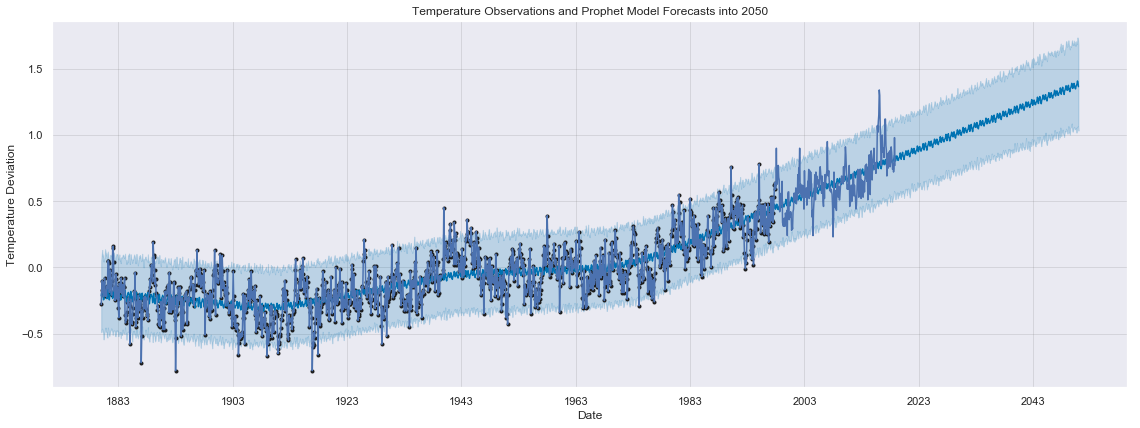

In [385]:
# Plot Observations and Prophet Predictions
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
prophet_model.plot(prophet_forecast_2050, uncertainty=True, ax=ax, xlabel='Date', ylabel='Temperature Deviation')
plt.plot(ts)
plt.title("Temperature Observations and Prophet Model Forecasts into 2050")

#### Analysis:
Our model forecast an unfortunate trend of temperature increments for the years to come, which seams like a reasonable forecast. :(

## Conclusions

Comparing the three models in simple and broad terms:
1. ARIMA offers a good level of flexibility in building our model, and it requires (for better or worse) an understanding of the statistical properties of time series. Therefore it is interpretable, especially when the theory is understood.
2. RNN can have tremendous flexibility, as we can design our networks in many different ways. This can make the models themselves and their results hard to interpret. Also, for forecasting many steps into the future one needs to get creative on how to do it. Depending on the data available this may be an inpediment.
3. Prophet offers a decent level of flexibility, a great level of interpretability (especially with its make_future_dataframe function), and it's incredibly straightforward. It may not require you to understand the properties of your data or of time series in general as much as ARIMA, but if the interest is in prediction rather than inference it's a terrific option.

As mentioned at the beginning, the three time series models used here (ARIMA, RNN and Prophet) make predictions based on behaviors observed in the data, of course. That means they are not able to account for external factors. For this reason, the temperature increment we forecasted could be higher or lower (probably lower) than what is shown in our Prophet prediction because of other factors that might shift the previously observed trend. Just because something has been a certain way in the past doesn't mean it will continue to be so. Therefore, here are some additional considerations for when working with time series:
1. Externalities and events that might be forecasted to affect the behavior of our time series in the future (e.g. a technology that allows us to sequester massive amounts of carbon from the atmosphere to reduce global temparatures) should be modeled when possible.
2. **Nested Cross Validation** is a good technique to use when tuning our hyperparameters. It can reduce the amount of overfitting and therefore increase generalization of our models. That way you evaluate parameters based on the performance of their predictions, and not simply on how well they fit the data during training.
3. There are many parameters that we did not play with, but that the different models offer to provide more predictive power. It's always a good idea to tweak some (especially if you understand what they do) to compare error rates in performace.

    #### Thanks for reading! Kindly share if you found this useful or interesting :)